This is the Code for the FKAN Project in the Biostatistics Course 2024/2025

This Jupyter Notebook is to practice/test some thing on the general KAN algorithm before testing the federal KAN

In [29]:


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import Sequential
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import time
from functools import lru_cache
from torchvision import models
from torch.optim import lr_scheduler


Loading Dataset

In [ ]:
#Resizing Images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),          # Convert images to tensors
    # Adjust the mean and std based on your data characteristics if needed
])

# Load datasets
train_dataset = ImageFolder( '../data/chest_xray/train/', transform=transform)
valid_dataset = ImageFolder('../data/chest_xray/val/', transform=transform)
test_dataset = ImageFolder('../data/chest_xray/test/', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Test to see if Images are loaded

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.58431375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.69411767].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5372549].


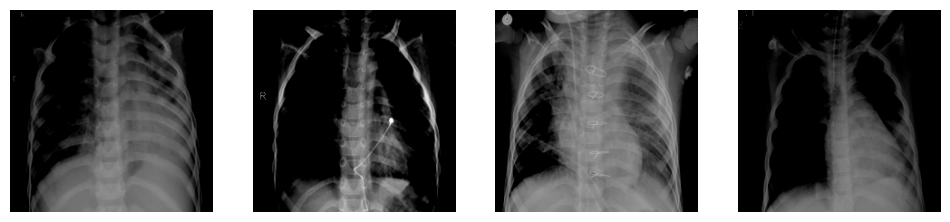

In [31]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Convert tensors to NumPy arrays and display them
images = images.numpy()  # Convert to NumPy
images = images.transpose((0, 2, 3, 1))  # Rearrange dimensions from (N, C, H, W) to (N, H, W, C)

# Plot the images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')  # Hide the axes
plt.show()

KAN Code (Taken inspiration from given Documents, errors still present)

In [ ]:
class KAL_Net(nn.Module):  # Kolmogorov Arnold Legendre Network (KAL-Net)
    def __init__(self, layers_hidden, polynomial_order=3, base_activation=nn.SiLU):
        super(KAL_Net, self).__init__()  # Initialize the parent nn.Module class
        
        # layers_hidden: A list of integers specifying the number of neurons in each layer
        self.layers_hidden = layers_hidden
        # polynomial_order: Order up to which Legendre polynomials are calculated
        self.polynomial_order = polynomial_order
        # base_activation: Activation function used after each layer's computation
        self.base_activation = base_activation()
        
        # ParameterList for the base weights of each layer
        self.base_weights = nn.ParameterList()
        # ParameterList for the polynomial weights for Legendre expansion
        self.poly_weights = nn.ParameterList()
        # ModuleList for layer normalization for each layer's output
        self.layer_norms = nn.ModuleList()

        # Initialize network parameters
        for i, (in_features, out_features) in enumerate(zip(layers_hidden, layers_hidden[1:])):
            # Base weight for linear transformation in each layer
            self.base_weights.append(nn.Parameter(torch.randn(out_features, in_features)))
            # Polynomial weight for handling Legendre polynomial expansions
            self.poly_weights.append(nn.Parameter(torch.randn(out_features, in_features * (polynomial_order + 1))))
            # Layer normalization to stabilize learning and outputs
            self.layer_norms.append(nn.LayerNorm(out_features))

        # Layer of output for binary classification (1 output unit)
        self.output_layer = nn.Linear(layers_hidden[-1], 1)

        # Initialize weights using Kaiming uniform distribution for better training start
        for weight in self.base_weights:
            nn.init.kaiming_uniform_(weight, nonlinearity='linear')
        for weight in self.poly_weights:
            nn.init.kaiming_uniform_(weight, nonlinearity='linear')

    @lru_cache(maxsize=128)  # Cache to avoid recomputation of Legendre polynomials
    def compute_legendre_polynomials(self, x, order):
        # Base case polynomials P0 and P1
        P0 = x.new_ones(x.shape)  # P0 = 1 for all x
        if order == 0:
            return P0.unsqueeze(-1)
        P1 = x  # P1 = x
        legendre_polys = [P0, P1]
        
        # Compute higher order polynomials using recurrence
        for n in range(1, order):
            Pn = ((2.0 * n + 1.0) * x * legendre_polys[-1] - n * legendre_polys[-2]) / (n + 1.0)
            legendre_polys.append(Pn)
        
        return torch.stack(legendre_polys, dim=-1)

    def forward(self, x):
        # Ensure x is on the right device from the start, matching the model parameters
        x = x.to(self.base_weights[0].device)

        for i, (base_weight, poly_weight, layer_norm) in enumerate(zip(self.base_weights, self.poly_weights, self.layer_norms)):
            # Apply base activation to input and then linear transform with base weights
            base_output = F.linear(self.base_activation(x), base_weight)
            
            # Normalize x to the range [-1, 1] for stable Legendre polynomial computation
            x_normalized = 2 * (x - x.min()) / (x.max() - x.min()) - 1
            # Compute Legendre polynomials for the normalized x
            legendre_basis = self.compute_legendre_polynomials(x_normalized, self.polynomial_order)
            # Reshape legendre_basis to match the expected input dimensions for linear transformation
            legendre_basis = legendre_basis.view(x.size(0), -1)

            # Compute polynomial output using polynomial weights
            poly_output = F.linear(legendre_basis, poly_weight)
            # Combine base and polynomial outputs, normalize, and activate
            x = self.base_activation(layer_norm(base_output + poly_output))

        # Final output layer for binary classification with sigmoid activation
        x = self.output_layer(x)
        return torch.sigmoid(x)  # Sigmoid to get a value between 0 and 1


Training the Model


In [ ]:
# Model definition (using a pretrained model for demonstration)
# Let's assume you're using a model like ResNet for image classification
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification (2 classes)

# Move model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Scheduler for learning rate reduction
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function with Early Stopping
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        print(f'Train Loss: {train_loss:.4f} Train Acc: {train_accuracy:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, val_preds = torch.max(outputs, 1)
                val_correct += torch.sum(val_preds == labels).item()
                val_total += labels.size(0)

        val_loss /= len(valid_loader.dataset)
        val_accuracy = val_correct / val_total
        print(f'Validation Loss: {val_loss:.4f} Validation Acc: {val_accuracy:.4f}')

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print('Model saved!')
        else:
            epochs_no_improve += 1
            print(f'Early Stopping Counter: {epochs_no_improve}/{patience}')

        # Early stopping
        if epochs_no_improve >= patience:
            print('Early stopping triggered.')
            break

        # Update the learning rate
        scheduler.step()

# Call the training function
train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5)

C:\Users\rateb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rateb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\rateb/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<0

Epoch 1/25
Train Loss: 0.1096 Train Acc: 0.9626
Validation Loss: 0.7625 Validation Acc: 0.8125
Model saved!
Epoch 2/25
Train Loss: 0.0708 Train Acc: 0.9743
Validation Loss: 0.3864 Validation Acc: 0.8125
Model saved!
Epoch 3/25
Train Loss: 0.0447 Train Acc: 0.9826
Validation Loss: 0.0778 Validation Acc: 1.0000
Model saved!
Epoch 4/25
Train Loss: 0.0438 Train Acc: 0.9849
Validation Loss: 0.0223 Validation Acc: 1.0000
Model saved!
Epoch 5/25
Train Loss: 0.0288 Train Acc: 0.9893
Validation Loss: 0.0367 Validation Acc: 1.0000
Early Stopping Counter: 1/5
Epoch 6/25
Train Loss: 0.0234 Train Acc: 0.9919
Validation Loss: 0.7931 Validation Acc: 0.8125
Early Stopping Counter: 2/5
Epoch 7/25
Train Loss: 0.0233 Train Acc: 0.9912
Validation Loss: 0.0322 Validation Acc: 1.0000
Early Stopping Counter: 3/5
Epoch 8/25
Train Loss: 0.0065 Train Acc: 0.9979
Validation Loss: 0.0135 Validation Acc: 1.0000
Model saved!
Epoch 9/25
Train Loss: 0.0042 Train Acc: 0.9990
Validation Loss: 0.0223 Validation Acc: 1.0

KeyboardInterrupt: 

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()  # Per classificazione multi-classe o binaria

# Carica il modello salvato
model = ConvNeXtKAN().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Modalità di valutazione

# Dati di test
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)  # Usa i tuoi dati di test
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)  # Usa le tue etichette di test

# Aggiungi la dimensione del canale per il modello (1 canale per immagini in scala di grigio)
test_images_tensor = test_images_tensor.unsqueeze(1)  # Shape: (n_test, 1, 150, 150)

# Crea il dataset e DataLoader per il test
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Calcola la loss e l'accuracy sui dati di test
test_loss = 0.0
correct_preds = 0
total_preds = 0
all_preds = []
all_labels = []

with torch.no_grad():  # Non calcolare i gradienti durante il test
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calcolo della perdita
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        # Calcolo delle predizioni
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

        # Memorizza le predizioni e le etichette per il calcolo di F1
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcolo della loss media e accuratezza finale
test_loss /= len(test_loader.dataset)
test_accuracy = correct_preds / total_preds

# Calcola F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")